# Kaggle Thermophysical Property: Melting Point 

### Machine Learning Regression using LightGBM, CatBoost, and XGBoost with PyMLR

The regression analyses in this notebook resulted in the following public scores on the Kaggle Leaderboard:

- Ensemble average public score (LightGBM, CatBoost, & XGBoost): 23.063
- LightGBM public score: 23.97874
- CatBoost public score: 23.30236
- XGBoost public score: 23.79370

The Kaggle thermophysical property melting point competition is described at the following link: 

https://www.kaggle.com/competitions/melting-point/overview

The goal is to build ML models that predict melting point in temperature units of Kelvin for organic compounds given molecular descriptors.

- **Objective**: Predict melting point (°C) for organic compounds given molecular descriptors 
- **Evaluation**: Mean Absolute Error (MAE) on a held-out test set. Lower is better.  

This notebook uses LightGBM, CatBoost, and XGBoost as implemented in the following functions from the PyMLR library (https://github.com/gjpelletier/PyMLR) to perform automated 5-fold cross-validated Bayesian optimization of hyperparameters using iterative trials with optuna to optimize the cross_val_score of model mean absolute error:

 - **lgbm_auto** - LightGBM LGBMRegressor
 - **catboost_auto** - CatBoostRegressor
 - **xgb_auto** - XGBRegressor

The user provides an input range of hyperparameter values to the PyMLR functions, and the functions use an adaptive Bayesian approach to determine the optimum values of each hyperparameter with 5-fold CV using RepeatedKFold in the optuna objective function to optimize the cross_val_score for model mean absolute error score by iterative trials. 

LightGBM, CatBoost, and XGBoost can automatically infer categorical features if they are explicitly marked as categorical in a pandas DataFrame. When a column in a pandas DataFrame is of category dtype, LightGBM and XGBoost recognize it as a categorical feature without requiring additional specification or one-hot encoding. CatBoost has the same capability but requires a argument cat_features, which is a list of the feature column names to treat as categories, and reqires the cat_features columns to bestr or int dtype. This simplifies preprocessing and ensures that categorical features are handled appropriately during training.

The PyMLR function preprocesses X to standardize continuous features (using StandardScaler). The PyMLR functions also have the capability of one-hot encoding any categorical features, although this capability is not used in this application. The functions also provide outputs of the scaler, encoder, and selected features used for the training dataset so that the same scaler, encoder, and selected features can be used to make predictions with the test data set used for submission to the competition.

The method is presented below showing the following three steps:

1) Train the model using X_train and y_train from the kaggle data and produce output of the model skill metrics and graphics including the best cross_val_score from the k-fold CV, and skill metrics and residual plots of the final fitted model.
2) Test predictions of the response variable using X_test from the kaggle data for submission to the Kaggle competition.
3) Interpretability analysis to show **a)** the optuna results of the optimum set of hyperparameters, the optimization history (cv score for each trial), relative importance of each hyperparameter on model predictions, and the contour plots of the model accuracy vs the two most important hyperparameters, and **b)** the model agnostics using to show the feature importance of the most important model features.

### PyMLR description and installation

PyMLR (https://github.com/gjpelletier/PyMLR) is a Python module designed to simplify the use of various machine learning libraries and tools for regression and classification tasks. 

Run the following code in your Python environment to install PyMLR if you have not already installed it:

In [1]:
# !pip install git+https://github.com/gjpelletier/PyMLR.git --upgrade

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit import RDLogger
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
RDLogger.DisableLog('rdApp.*')

### Read the train and test data

In this section we will perform the following steps:

- read the train.csv and test.csv in to dataframes df_train and df_test
- check the dtypes and numbers of missing values of each column of data
- prepare X_train and y_train for use in training, and X_test for use in predicting the response variable for submission to the competition

In [2]:
# Read the train and test data downloaded from kaggle at the following link:
# https://www.kaggle.com/competitions/playground-series-s5e8/data

# NOTE: edit file paths as needed for your file system

import pandas as pd

# read train data into dataframe train
train_path = "/mnt/c/z/kaggle/melting_point/train.csv"
df_train = pd.read_csv(train_path)
print("Train dataset shape is {}".format(df_train.shape))

# read test data into dataframe test
test_path = "/mnt/c/z/kaggle/melting_point/test.csv"
df_test = pd.read_csv(test_path)
print("Test dataset shape is {}".format(df_test.shape))

Train dataset shape is (2662, 427)
Test dataset shape is (666, 426)


### Add chemical properties from SMILES into X_train and X_test

In [3]:
descriptor_list = [d[0] for d in Descriptors.descList]
TARGET = 'Tm'
SMILES_COL = 'SMILES'

# generate_features_from_smiles adapted from the following kaggle user notebook
# https://www.kaggle.com/code/benjaminlundkvist/melting-point-prediction-with-tuned-lightgbm
def generate_features_from_smiles(smiles_list):

    features = []
    
    for smiles in tqdm(smiles_list, desc="Processing SMILES"):
        mol = Chem.MolFromSmiles(smiles)
        feature_dict = {}
        
        if mol is not None:
            # Generate standard RDKit descriptors
            for name, func in Descriptors.descList:
                try:
                    feature_dict[name] = func(mol)
                except:
                    feature_dict[name] = 0
            
            # Generate Morgan fingerprint
            fp_morgan = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
            for i in range(fp_morgan.GetNumBits()):
                feature_dict[f"Morgan_{i}"] = int(fp_morgan.GetBit(i))
            
            # Generate MACCS keys fingerprint
            fp_maccs = rdMolDescriptors.GetMACCSKeysFingerprint(mol)
            for i in range(fp_maccs.GetNumBits()):
                feature_dict[f"MACCS_{i}"] = int(fp_maccs.GetBit(i))
        else:
            # Fallback zeros if molecule can't be parsed
            for name in descriptor_list:
                feature_dict[name] = 0
            for i in range(1024):
                feature_dict[f"Morgan_{i}"] = 0
            for i in range(167):
                feature_dict[f"MACCS_{i}"] = 0
        
        features.append(feature_dict)
    
    return pd.DataFrame(features).fillna(0)

X_train = generate_features_from_smiles(df_train[SMILES_COL].tolist())
X_test = generate_features_from_smiles(df_test[SMILES_COL].tolist())
y_train = df_train[TARGET].values

Processing SMILES: 100%|█████████████████████████████████████████████████████████████| 666/666 [00:01<00:00, 458.10it/s]


In [5]:
# Add feature interactions adapted from the following kaggle user notebook:
# https://www.kaggle.com/code/taylorsamarel/solution-e

# X_train
X_train['HBond_Product'] = X_train['NumHDonors'] * X_train['NumHAcceptors']
X_train['HBond_Sum'] = X_train['NumHDonors'] + X_train['NumHAcceptors']
X_train['LogP_div_TPSA'] = X_train['MolLogP'] / (X_train['TPSA'] + 1)
X_train['LogP_x_TPSA'] = X_train['MolLogP'] * X_train['TPSA']
X_train['Flexibility_Score'] = X_train['NumRotatableBonds'] / (X_train['MolWt'] + 1)
X_train['MolWt_x_AromaticRings'] = X_train['MolWt'] * X_train['NumAromaticRings']
X_train['Complexity_per_MW'] = X_train['BertzCT'] / (X_train['MolWt'] + 1)
X_train['Rigidity_Score'] = X_train['NumAromaticRings'] / (X_train['NumRotatableBonds'] + 1)

# X_test
X_test['HBond_Product'] = X_test['NumHDonors'] * X_test['NumHAcceptors']
X_test['HBond_Sum'] = X_test['NumHDonors'] + X_test['NumHAcceptors']
X_test['LogP_div_TPSA'] = X_test['MolLogP'] / (X_test['TPSA'] + 1)
X_test['LogP_x_TPSA'] = X_test['MolLogP'] * X_test['TPSA']
X_test['Flexibility_Score'] = X_test['NumRotatableBonds'] / (X_test['MolWt'] + 1)
X_test['MolWt_x_AromaticRings'] = X_test['MolWt'] * X_test['NumAromaticRings']
X_test['Complexity_per_MW'] = X_test['BertzCT'] / (X_test['MolWt'] + 1)
X_test['Rigidity_Score'] = X_test['NumAromaticRings'] / (X_test['NumRotatableBonds'] + 1)

# PyMLR lgbm_auto - LightGBM with one-hot categorical

Running optuna to find best parameters, could take a few minutes, please wait...
Trial 1, best cv test score so far: -29.297360 ...
Trial 2, best cv test score so far: -29.297360 ...
Trial 3, best cv test score so far: -29.297360 ...
Trial 4, best cv test score so far: -27.816309 ...
Trial 5, best cv test score so far: -27.816309 ...
Trial 6, best cv test score so far: -27.705983 ...
Trial 7, best cv test score so far: -27.705983 ...
Trial 8, best cv test score so far: -27.705983 ...
Trial 9, best cv test score so far: -27.705983 ...
Trial 10, best cv test score so far: -27.705983 ...
Trial 11, best cv test score so far: -27.705983 ...
Trial 12, best cv test score so far: -27.550267 ...
Trial 13, best cv test score so far: -27.550267 ...
Trial 14, best cv test score so far: -27.550267 ...
Trial 15, best cv test score so far: -27.550267 ...
Trial 16, best cv test score so far: -27.550267 ...
Trial 17, best cv test score so far: -27.550267 ...
Trial 18, best cv test score so far: -27.550

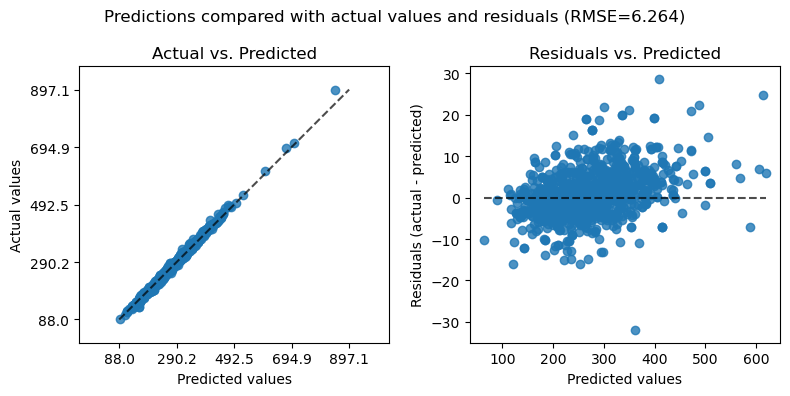

In [9]:
# 1. Train the model using X_train and y_train

kwargs = {

    # PyMLR, optuna, and cross_val_score hyperparameters
    'n_trials': 25,              # number of optuna trials
    'classify': False,           # True= LGBMClassifier, False= LGBMRegressor
    'feature_selection': False,  # True= optimize selected features
    'threshold_cat': 12,         # one-hot encode <= threshold_cat
    'enable_categorical': False, # bypass category dtype in proprocess
    'scoring': "neg_mean_absolute_error",
    'random_state': 42,          # random seed for reproducibility

    # LightGBM hyperparameters (ranges optimized by optuna)
    'num_threads': 8,            # available cpus for LGBM, -1 to use all cpus
    'objective': 'regression',   # 'regression', 'binary', or 'multiclass'
    'verbosity': -1,                                    
    # 'learning_rate': [1e-3, 0.5],
    # 'n_estimators': [100, 2500],
    'learning_rate': [1e-3, 1],   # v03e02
    'n_estimators': [100, 3000],   # v03e02
    'num_leaves': [16, 256],
    'max_depth': [3, 15],
    'min_child_samples': [5, 100],
    'subsample': [0.5, 1.0],
    'colsample_bytree': [0.5, 1.0],
    'reg_alpha': [1e-8, 10.0],
    'reg_lambda': [1e-8, 10.0],
    'min_split_gain': [0.0, 1.0],
    'min_child_weight': [1e-3, 10.0],
    'class_weight': [None, "balanced"],
    'boosting_type': ["gbdt", "dart"],

}

# Fit the model with the training data
from PyMLR import lgbm_auto
train_model_lgbm, train_output_lgbm = lgbm_auto(X_train, y_train, **kwargs)

In [ ]:
# 2. Test predictions and submission.csv
# public leaderboard score: 23.97874

# NOTE: edit file paths as needed for your file system

from PyMLR import preprocess_test

preprocess_result= train_output_lgbm['preprocess_result']
selected_features= train_output_lgbm['selected_features']
X_test_proc = preprocess_test(X_test, preprocess_result)
model = train_model_lgbm
y_pred = model.predict(X_test_proc[selected_features])

# Save your predictions as a CSV
to_save = df_test[['id']].copy()
to_save.loc[:, 'Tm'] = y_pred
to_save.to_csv('/mnt/c/z/kaggle/melting_point/submission_lgbm_auto_v03e04.csv', index=False)

Best parameters:

learning_rate: 0.14305690654155667
max_depth: 5
n_estimators: 2796
min_child_samples: 16
subsample: 0.9376288351572138
colsample_bytree: 0.7015748111235666
reg_lambda: 8.970351837246337e-07
reg_alpha: 0.0004154610793169194
num_leaves: 170
min_split_gain: 0.836327723427677
min_child_weight: 0.9266567352268245
boosting_type: dart

Best score: -26.88842019581143



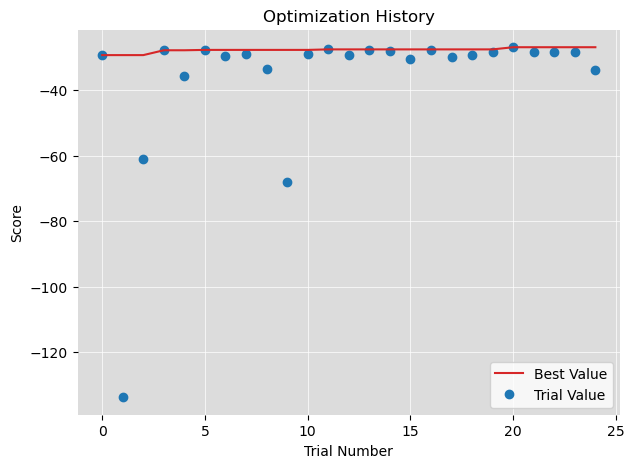

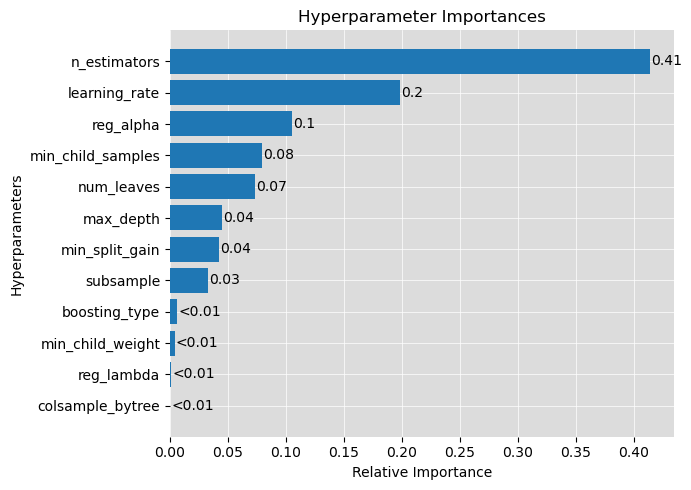

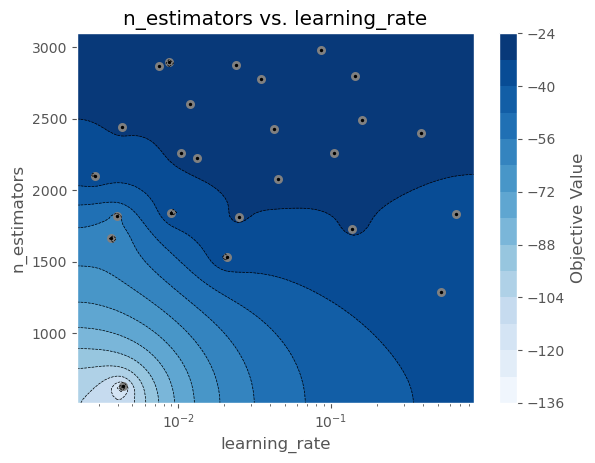

In [11]:
# 3a. Optuna results
from PyMLR import show_optuna
optuna_result_lgbm = show_optuna(train_output_lgbm['optuna_study'])

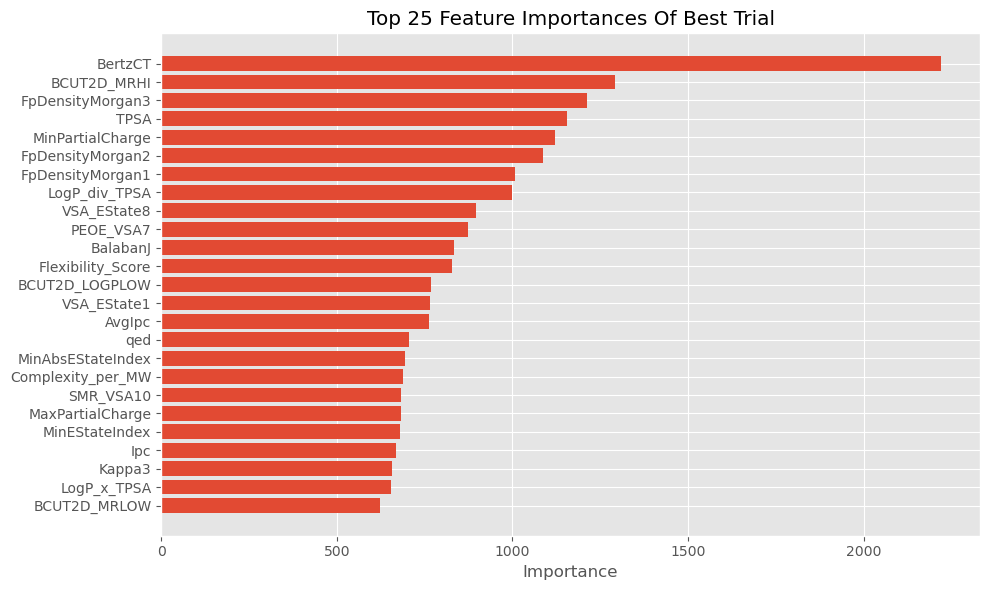

In [12]:
# 3b. Model agnostic bar plot of the top 25 feature importances for the best optuna trial of LightGBM

feature_importances = train_output_lgbm['feature_importances']
feature_names = train_output_lgbm['feature_names']

df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False).head(25)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df['Feature'][::-1], df['Importance'][::-1])  # Reverse for descending order
plt.xlabel("Importance")
plt.title("Top 25 Feature Importances Of Best Trial")
plt.tight_layout()
plt.show()

# PyMLR catboost_auto - CatBoost with one-hot categorical

Current working directory has no write permission: /mnt
Working directory changed to: /home/heron/pymlr
Running optuna to find best parameters, could take a few minutes, please wait...
Trial 1, best cv test score so far: -28.204890 ...
Trial 2, best cv test score so far: -28.012562 ...
Trial 3, best cv test score so far: -28.012562 ...
Trial 4, best cv test score so far: -28.012562 ...
Trial 5, best cv test score so far: -28.012562 ...
Trial 6, best cv test score so far: -28.012562 ...
Trial 7, best cv test score so far: -27.452540 ...
Trial 8, best cv test score so far: -27.452540 ...
Trial 9, best cv test score so far: -27.452540 ...
Trial 10, best cv test score so far: -27.452540 ...
Trial 11, best cv test score so far: -27.452540 ...
Trial 12, best cv test score so far: -27.452540 ...
Trial 13, best cv test score so far: -27.452540 ...
Trial 14, best cv test score so far: -27.452540 ...
Trial 15, best cv test score so far: -27.346284 ...
Trial 16, best cv test score so far: -27.034

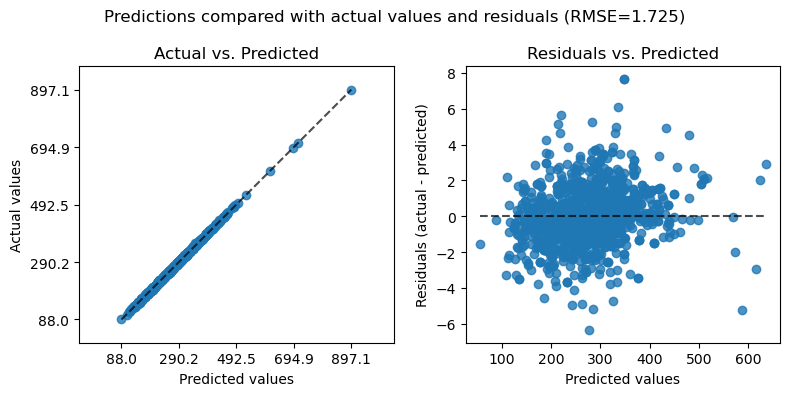

In [6]:
# 1. Train the model using X_train and y_train

kwargs = {

    # PyMLR, optuna, and cross_val_score hyperparameters
    'n_trials': 25,
    'classify': False,        # True= CatBoostClassifier, False= CatBoostRegressor
    'feature_selection': False,
    'threshold_cat': 12,         # one-hot encode <= threshold_cat
    # 'bypass_cols': cat_dtype_cols,      # bypass these cols in preprocess
    'scoring': "neg_mean_absolute_error",
    'random_state': 42,                 # random seed for reproducibility

    # CatBoost hyperparameters (ranges optimized by optuna)
    'thread_count': 8,                  # num of available cpus
    # 'cat_features': cat_dtype_cols,     # use category dtypes as cat_features
    'learning_rate': [0.01, 0.3],       # Balances step size in gradient updates.
    'depth': [4, 10],                   # Controls tree depth
    'iterations': [100, 3000],          # Number of boosting iterations
    'l2_leaf_reg': [1, 10],             # Regularization strength       
    'random_strength': [0, 1],          # Adds noise for diversity
    'bagging_temperature': [0.1, 1.0],  # Controls randomness in sampling
    'border_count': [32, 255],          # Number of bins for feature discretization
    'min_data_in_leaf': [1, 100],       # Minimum samples per leaf         
    'max_bin': [64, 255],               # Number of bins for feature quantization

}    

from PyMLR import catboost_auto
train_model_cat, train_output_cat = catboost_auto(X_train, y_train, **kwargs)

In [ ]:
# 2. Test predictions using X_test_cat and submission.csv
# public leaderboard score: 23.30236

# NOTE: edit file paths as needed for your file system

from PyMLR import preprocess_test

preprocess_result= train_output_cat['preprocess_result']
selected_features= train_output_cat['selected_features']
X_test_proc = preprocess_test(X_test, preprocess_result)
model = train_model_cat
y_pred = model.predict(X_test_proc[selected_features])

# Save your predictions as a CSV
to_save = df_test[['id']].copy()
to_save.loc[:, 'Tm'] = y_pred
to_save.to_csv('/mnt/c/z/kaggle/melting_point/submission_catboost_auto_v03e.csv', index=False)

Best parameters:

subsample: 0.6137698047116499
colsample_bylevel: 0.16167612520966373
learning_rate: 0.06223702585846798
depth: 9
iterations: 2635
l2_leaf_reg: 9.160065682287462
random_strength: 0.10968955413698828
bagging_temperature: 0.5170795754065616
min_data_in_leaf: 13
grow_policy: Depthwise
use_border_count: True
border_count: 108

Best score: -27.083797455269814



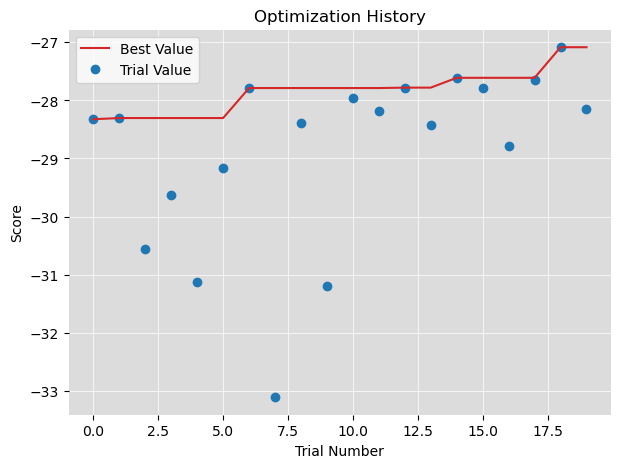

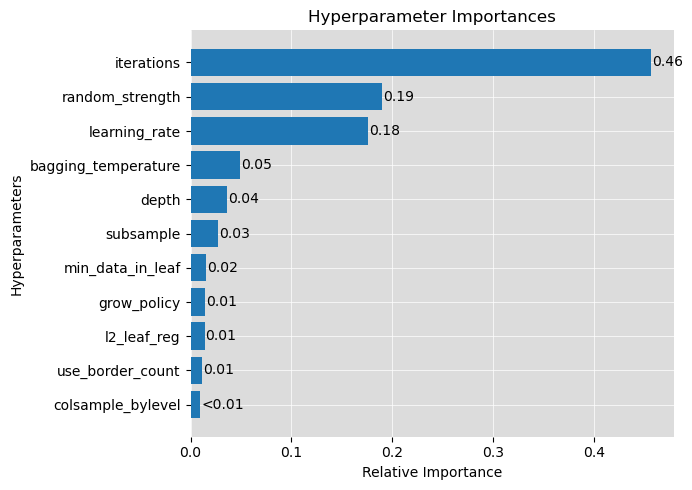

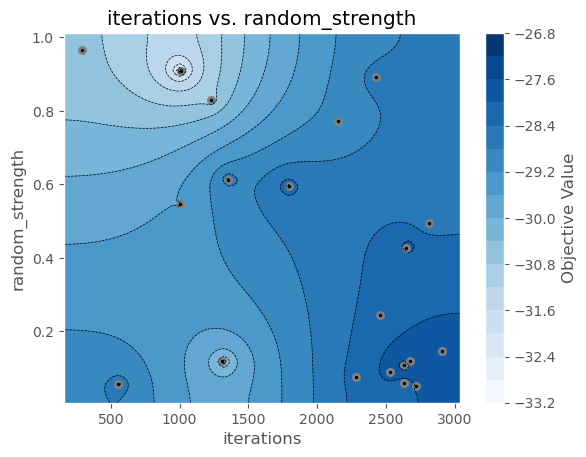

In [10]:
# 3a. Optuna results
from PyMLR import show_optuna
optuna_result_cat = show_optuna(train_output_cat['optuna_study'])

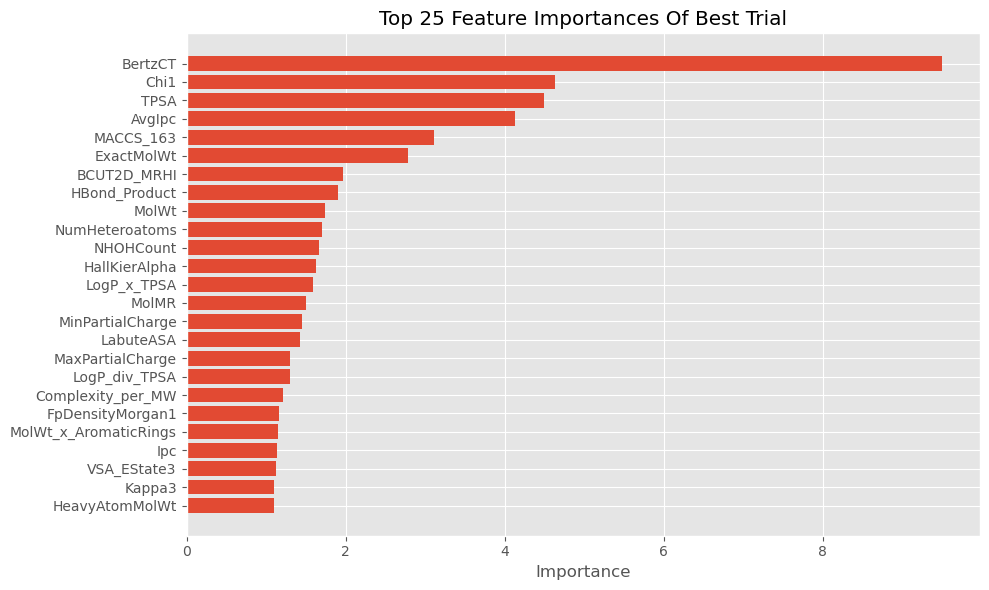

In [11]:
# 3b. Model agnostic bar plot of the top 25 feature importances for the best optuna trial of LightGBM

feature_importances = train_output_cat['feature_importances']
feature_names = train_output_cat['feature_names']

df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False).head(25)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df['Feature'][::-1], df['Importance'][::-1])  # Reverse for descending order
plt.xlabel("Importance")
plt.title("Top 25 Feature Importances Of Best Trial")
plt.tight_layout()
plt.show()

# PyMLR xgb_auto - XGBoost with one-hot categorical

Running optuna to find best parameters, could take a few minutes, please wait...
Trial 1, best cv test score so far: -28.322107 ...
Trial 2, best cv test score so far: -27.995789 ...
Trial 3, best cv test score so far: -27.995789 ...
Trial 4, best cv test score so far: -27.469092 ...
Trial 5, best cv test score so far: -27.469092 ...
Trial 6, best cv test score so far: -27.019364 ...
Trial 7, best cv test score so far: -27.019364 ...
Trial 8, best cv test score so far: -27.019364 ...
Trial 9, best cv test score so far: -27.019364 ...
Trial 10, best cv test score so far: -26.914108 ...
Trial 11, best cv test score so far: -26.641390 ...
Trial 12, best cv test score so far: -26.641390 ...
Trial 13, best cv test score so far: -26.641390 ...
Trial 14, best cv test score so far: -26.641390 ...
Trial 15, best cv test score so far: -26.641390 ...
Trial 16, best cv test score so far: -26.641390 ...
Trial 17, best cv test score so far: -26.641390 ...
Trial 18, best cv test score so far: -26.641

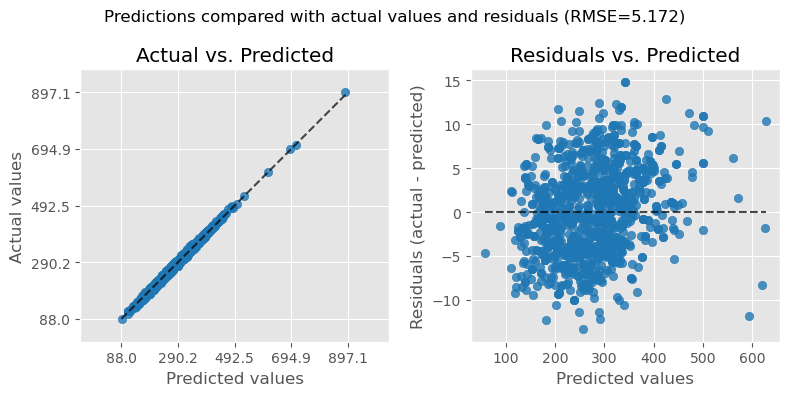

In [17]:
# 1. Train the model using X_train and y_train

kwargs = {

    # PyMLR, optuna, and cross_val_score hyperparameters
    'gpu': False,                   # True= use GPU, False= use CPU
    'n_trials': 50,                 # number of optuna trials
    'feature_selection': False,
    'threshold_cat': 12,            # one-hot encode <= threshold_cat
    'scoring': "neg_mean_absolute_error",
    'show_trial_progress': True,
    'classify': False,              # False= XGBClassifier, True= XGBRegressor
    'random_state': 42,             # random seed for reproducibility

    # XGBoost hyperparameters (ranges optimized by optuna)
    'nthread': 8,                    # number of cpu cores
    # 'enable_categorical': True,
    'learning_rate': [1e-4, 1.0],   # step size shrinkage (also called eta)
    'max_depth': [3, 15],           # maximum depth of a tree
    'min_child_weight': [1, 10],    # minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.5, 1],          # fraction of samples used for training each tree
    'colsample_bytree': [0.5, 1],   # fraction of features used for each tree
    'gamma': [1e-8, 10.0],          # minimum loss reduction to make a split
    'reg_lambda': [1e-8, 10.0],     # L2 regularization term on weights
    'alpha': [1e-8, 10.0],          # L1 regularization term on weights
    'n_estimators': [100, 2000]     # number of boosting rounds (trees)

}    

from PyMLR import xgb_auto
train_model_xgb, train_output_xgb = xgb_auto(X_train, y_train, **kwargs)

In [ ]:
# 2. Test predictions and submission.csv
# public leaderboard score: 23.79370

# NOTE: edit file paths as needed for your file system

from PyMLR import preprocess_test

preprocess_result= train_output_xgb['preprocess_result']
selected_features= train_output_xgb['selected_features']
X_test_proc = preprocess_test(X_test, preprocess_result)
model = train_model_xgb
y_pred = model.predict(X_test_proc[selected_features])

# Save your predictions as a CSV
to_save = df_test[['id']].copy()
to_save.loc[:, 'Tm'] = y_pred
to_save.to_csv('/mnt/c/z/kaggle/melting_point/submission_xgb_auto_v03e.csv', index=False)

Best parameters:

learning_rate: 0.027484412121272454
max_depth: 6
min_child_weight: 1
subsample: 0.5766245065033628
colsample_bytree: 0.5876018797805902
gamma: 0.006180129319786354
reg_lambda: 3.0100010341606186e-05
alpha: 0.04695468292318865
n_estimators: 1666

Best score: -26.641389635890523



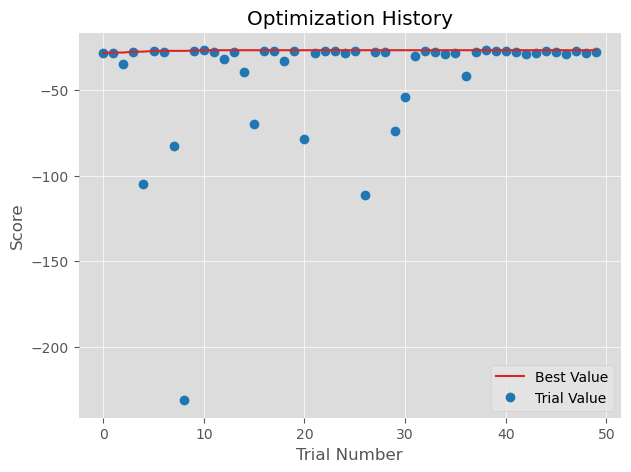

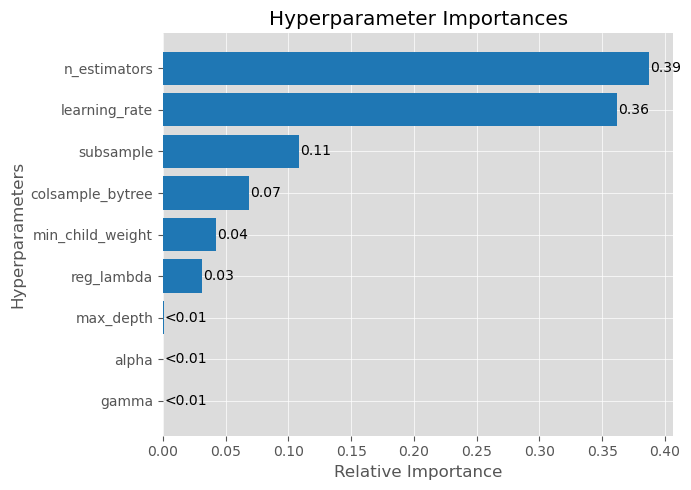

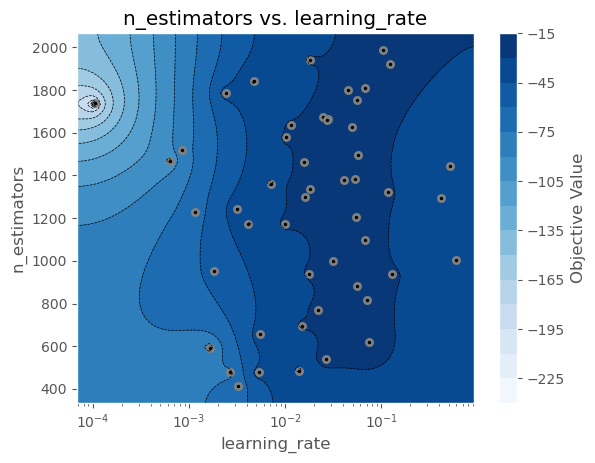

In [19]:
# 3a. Optuna results
from PyMLR import show_optuna
optuna_result_xgb = show_optuna(train_output_xgb['optuna_study'])

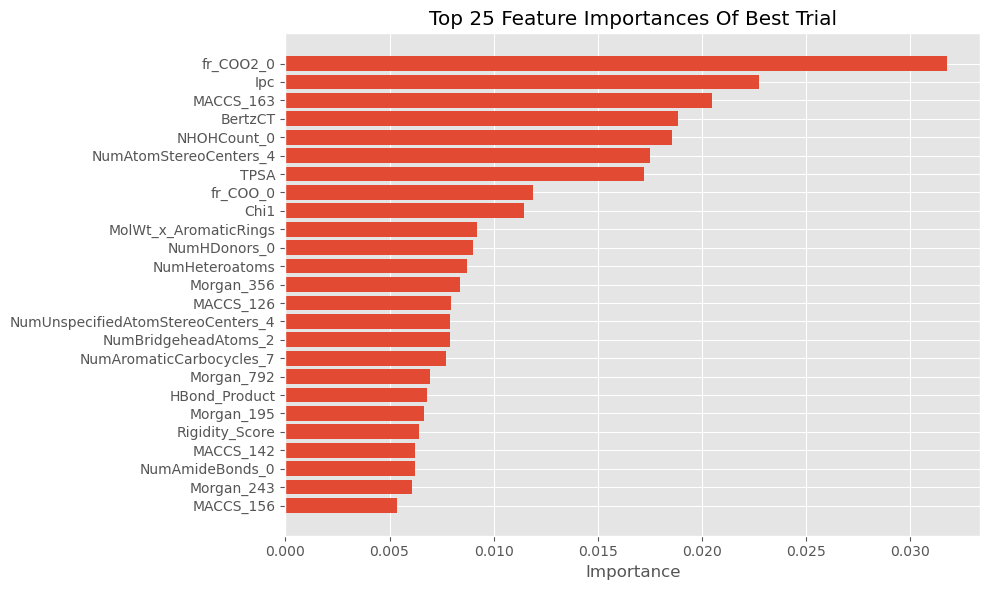

In [20]:
# 3b. Model agnostic bar plot of the top 25 feature importances for the best optuna trial of LightGBM

feature_importances = train_output_xgb['feature_importances']
feature_names = train_output_xgb['feature_names']

df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False).head(25)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df['Feature'][::-1], df['Importance'][::-1])  # Reverse for descending order
plt.xlabel("Importance")
plt.title("Top 25 Feature Importances Of Best Trial")
plt.tight_layout()
plt.show()

# Ensemble average predictions 

Next we will create a submission of the average of predictions of Tm from LightGBM, CatBoost, and XGBoost

- **Public score of the ensemble averages of LightGBM, CatBoost, XGBoost: 23.063**

In [ ]:
# Read the submission files for LightGBM, CatBoost, and XGBoost 
# and calculate ensemble average predicitons

# NOTE: edit file paths as needed for your file system

# LightGBM submission
sub_path_lgbm = "/mnt/c/z/kaggle/melting_point/submission_lgbm_auto_v03e04.csv"
df_sub_lgbm = pd.read_csv(sub_path_lgbm)
y_pred_lgbm = df_sub_lgbm['Tm']

# CatBoost submission
sub_path_catboost = "/mnt/c/z/kaggle/melting_point/submission_catboost_auto_v03e.csv"
df_sub_catboost = pd.read_csv(sub_path_catboost)
y_pred_catboost = df_sub_catboost['Tm']

# XGBoost submission
sub_path_xgb = "/mnt/c/z/kaggle/melting_point/submission_xgb_auto_v03e.csv"
df_sub_xgb = pd.read_csv(sub_path_xgb)
y_pred_xgb = df_sub_xgb['Tm']

# Ensemble average prediction from LightGBM, CatBoost, and XGBoost
y_pred_ensemble_v03e04 = (y_pred_lgbm + y_pred_catboost + y_pred_xgb) / 3

# Save the ensemble average predictions as a CSV
to_save = df_test[['id']].copy()
to_save.loc[:, 'Tm'] = y_pred_ensemble_v03e04
to_save.to_csv('/mnt/c/z/kaggle/melting_point/submission_ensemble_v03e04.csv', index=False)